# Pepper.com case study


### task

1. General Marketing analytics questions.

  a. What could be, in your opinion, the top 3 reasons why Pepper users churn?
  
  b. How would you proceed to verify this hypothesis? Please explain your steps, the tools you would use, and what you would do with your conclusion.
  
  c. The Head of Marketing asks you for help: he needs to assign the marketing budget for the next year and would like to make a data-informed decision. What would be your process to answer his question? What data would you need to give him solid recommendations? How would you set priorities?


2. Please have a look at the attached data sample. It shows you the paid user (users we acquired through paid campaigns) activity on our app over 7 days. Write a SQL query to generate user cohorts from this table. What conclusions can you draw from these cohorts?


In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy import stats as st
from IPython.display import Markdown as md
import warnings
warnings.simplefilter("ignore")

## Data preparation 

In [2]:
df = pd.read_excel('Case study for Marketing Data Analyst - Data sample.xlsx')

In [3]:
df.head()

,activity,network,event_date,installed_at,device
0,session,Google Ads ACI,2022-03-24,2022-03-22 09:58:00,id_232
1,session,Google Ads ACI,2022-03-24,2022-03-18 12:43:15,id_053
2,install,Google Ads ACI,2022-03-24,2022-03-23 23:20:10,id_093
3,install,Facebook,2022-03-24,2022-03-23 23:26:14,id_357
4,session,Google Ads ACI,2022-03-24,2022-03-21 18:03:13,id_427


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   activity      611 non-null    object        
 1   network       611 non-null    object        
 2   event_date    611 non-null    datetime64[ns]
 3   installed_at  611 non-null    datetime64[ns]
 4   device        611 non-null    object        
dtypes: datetime64[ns](2), object(3)
memory usage: 24.0+ KB


probably no missies, all data is in rught format, the only thing that can be done is to check the way of prononciation of unique words in cells to see if they create an overlap.

for that i am going to use a loop, checking unique values in all columns.

In [52]:
list_of_columns = ['activity',
 'network',
 'event_date']

In [53]:
for j in list_of_columns:
    print(j)
    print(df[j].unique())
    print('--------------------------------------------------')
    print('')

activity
['session' 'install']
--------------------------------------------------

network
['Google Ads ACI' 'Facebook' 'TikTok']
--------------------------------------------------

event_date
['2022-03-24' '2022-03-23' '2022-03-22' '2022-03-21' '2022-03-20'
 '2022-03-19' '2022-03-18']
--------------------------------------------------



In [6]:
df = df.drop_duplicates()

Seems like everything is just fine

## Analysis

Let's try to answer first question: **What could be, in your opinion, the top 3 reasons why Pepper users churn?**



In [7]:
first_activity_date = df.groupby('device')['event_date'].min()
first_activity_date.name = 'first_activity_date'
df = df.join(first_activity_date,on='device')

In [8]:
df['device'].nunique()

572

In [9]:
ratio = (len(df['device'])  - df['device'].nunique())/len(df['device']) 

In [10]:
md("Retention is {} ".format(("{:.0%}".format(ratio))))

Retention is 6% 

Here we have 572 unique device id's out of 611 records in the table

In [11]:
converted = df.groupby('device')['installed_at'].count()
converted.name = 'number_of_uses'
df = df.join(converted , on='device')

In [12]:
df_converted = df[df['number_of_uses'] != 1]

In [13]:
random_id = df_converted['device'].sample().values[0]
df_converted.query("device == @random_id").sort_values(by='event_date', ascending=True)

,activity,network,event_date,installed_at,device,first_activity_date,number_of_uses
277,session,Google Ads ACI,2022-03-22,2022-03-20 00:38:21,id_553,2022-03-22,2
211,session,Google Ads ACI,2022-03-23,2022-03-20 00:38:21,id_553,2022-03-22,2


This is an axample of one of those several times mentioned device, just to check if everything works fine

as first installation date and first event date do not match each other, i wont to check if it works in a same way for the activity type "install"

In [14]:
df['retention'] = (df['number_of_uses'] > 1)
df = df[['activity', 'network', 'event_date', 'installed_at', 'first_activity_date', 'device', 'retention']]

In [15]:
df[df['activity'] == "install"]

,activity,network,event_date,installed_at,first_activity_date,device,retention
2,install,Google Ads ACI,2022-03-24,2022-03-23 23:20:10,2022-03-24,id_093,False
3,install,Facebook,2022-03-24,2022-03-23 23:26:14,2022-03-24,id_357,False
5,install,Facebook,2022-03-24,2022-03-23 23:23:38,2022-03-24,id_309,False
6,install,TikTok,2022-03-24,2022-03-23 23:18:02,2022-03-24,id_022,False
7,install,Google Ads ACI,2022-03-24,2022-03-23 23:57:00,2022-03-24,id_359,False
...,...,...,...,...,...,...,...
601,install,Google Ads ACI,2022-03-18,2022-03-17 23:48:09,2022-03-18,id_014,False
603,install,Google Ads ACI,2022-03-18,2022-03-17 23:21:04,2022-03-18,id_204,False
605,install,Google Ads ACI,2022-03-18,2022-03-17 23:12:30,2022-03-18,id_086,False
609,install,Facebook,2022-03-18,2022-03-17 23:36:14,2022-03-18,id_307,False


In [16]:
df['time_diff_hour'] = ( df['installed_at'] - df['first_activity_date'] ) / np.timedelta64(1, 'h')

<AxesSubplot:>

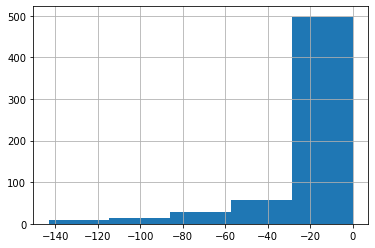

In [17]:
df['time_diff_hour'].hist(bins=5)

In [18]:
df['time_diff_hour'].median()

-0.9044444444444445

In [19]:
df[df['time_diff_hour'] > 0]

,activity,network,event_date,installed_at,first_activity_date,device,retention,time_diff_hour


In [20]:
df[df['time_diff_hour'] < 0]

,activity,network,event_date,installed_at,first_activity_date,device,retention,time_diff_hour
0,session,Google Ads ACI,2022-03-24,2022-03-22 09:58:00,2022-03-24,id_232,False,-38.033333
1,session,Google Ads ACI,2022-03-24,2022-03-18 12:43:15,2022-03-24,id_053,False,-131.279167
2,install,Google Ads ACI,2022-03-24,2022-03-23 23:20:10,2022-03-24,id_093,False,-0.663889
3,install,Facebook,2022-03-24,2022-03-23 23:26:14,2022-03-24,id_357,False,-0.562778
4,session,Google Ads ACI,2022-03-24,2022-03-21 18:03:13,2022-03-24,id_427,False,-53.946389
...,...,...,...,...,...,...,...,...
606,session,Google Ads ACI,2022-03-18,2022-03-17 10:20:20,2022-03-18,id_243,False,-13.661111
607,session,Google Ads ACI,2022-03-18,2022-03-17 19:21:23,2022-03-18,id_385,True,-4.643611
608,session,Google Ads ACI,2022-03-18,2022-03-17 12:18:12,2022-03-18,id_329,True,-11.696667
609,install,Facebook,2022-03-18,2022-03-17 23:36:14,2022-03-18,id_307,False,-0.396111


As we can see, the problem is somehow covered under delay of installation time and first event time. And this causes some obstacles, because it doesn't provide me a robust idea of what really is the first time of interaction with the web-page or either app. And all the records have this bias

In [21]:
df['event_date'].nunique()

7

Here we have only 7 unique dates recording events, so it doesn't give us a lot of sapce to create cohorts, but i assume, the idea here is to show, how many people are going to return after first activity, which probably should not be an installation

If we want to receive some interesting figures abour source of churn or on the other side retention, we need to exclude from data all repetative records.

In [22]:
df_limited = df[df['first_activity_date'] == df['event_date']]

In [23]:
len(df_limited)

572

this is what we need, now let's dig a little bit further, as all records with two or more sessions are assigned to one network, we dont't lose any important information

In [24]:
df_limited.groupby('network').agg({'retention': 'mean', 'device': 'nunique'})

,retention,device
network,,
Facebook,0.069444,72
Google Ads ACI,0.058315,463
TikTok,0.000000,37


So, what we see: Facebook provides 6.9% of retention (on 72 persons), Google Ads - 5.8 (on 463 persons), Tiktok - none (despite the fact is has 37 people in its bag) 

In [25]:
retention_Facebook =  df_limited.query("network == 'Facebook'")['retention']
retention_Google_Ads_ACI =  df_limited.query("network == 'Google Ads ACI'")['retention']
retention_TikTok =  df_limited.query("network == 'TikTok'")['retention']

In [26]:
def Welchs_t_test(data1, data2):
    alpha = 0.05  # critical level of statistical significance

    results = st.ttest_ind(data1, data2, equal_var = False)

    print('p-value: ', results.pvalue)

    if results.pvalue < alpha:
        print('We reject the null hypothesis: the difference is statistically significant')
    else:
        print(
            'Cannot reject null hypothesis, no difference can be made'
        ) 

To check if the difference between our samples (based on network) is statistically significant, i decided to use Welsh's test, because it is evoid problems of different sample sizes, which is a big point now 

In [27]:
Welchs_t_test(retention_Facebook, retention_Google_Ads_ACI)

p-value:  0.7294465431613948
Cannot reject null hypothesis, no difference can be made


In [28]:
Welchs_t_test(retention_Facebook, retention_TikTok)

p-value:  0.024280622219628678
We reject the null hypothesis: the difference is statistically significant


In [29]:
Welchs_t_test(retention_Google_Ads_ACI, retention_TikTok)

p-value:  1.3953276739283862e-07
We reject the null hypothesis: the difference is statistically significant


It is interesting, that Google and Facebook are close to each other, TikTok obviously is in another league 

In [30]:
df_limited.groupby('activity').agg({'retention': 'mean', 'device': 'nunique'})

,retention,device
activity,,
install,0.028490,351
session,0.099548,221


Assuming that activity install means in this case using of mobile app and session means visiting web page, we can see normally web page is more suitable for returning back, providing almost 10% of retention, while app only 351.  

In [31]:
retention_install =  df_limited.query("activity == 'install'")['retention']
retention_session =  df_limited.query("activity == 'session'")['retention']

In [32]:
Welchs_t_test(retention_install, retention_session)

p-value:  0.0014123907159237115
We reject the null hypothesis: the difference is statistically significant


Different activity types provide significantly different results in retention - that's also interesting. 

In [33]:
df_limited.groupby('first_activity_date').agg({'retention': 'mean', 'device': 'nunique'})

,retention,device
first_activity_date,,
2022-03-18,0.130435,46
2022-03-19,0.084337,83
2022-03-20,0.090000,100
2022-03-21,0.022222,90
2022-03-22,0.127660,47
2022-03-23,0.023810,84
2022-03-24,0.000000,122


very hard to say somethin particular about dates, but what is outstanding is that people whos first event date was on 21 of march and on on 23 of march showed very low figures for retention.

### Conclusion 

a. What could be, in your opinion, the top 3 reasons why Pepper users churn?

  1. i see as core feature/problem of your product - probabaly person came once to find answers for the needed item in the market, in other words, your product is not that all of people will use regularly. Even based on my experince, i need something like that maximum 2-3 times per year and more rich group of people is less concentrated on sales and others opinian, because they practically can afford much more without regrets of buying something non-relevant for them. 
  2. To return to product you need use it frequintly, trying not to forget about it, if your product helped once to the customer, it doesn't mean that it will help in future, as i believe there are no deals for everything there. So it is basically about amount of deals and reviews. 
  3. Other options on the market, which may better fit the requirements of a customer
  
b. How would you proceed to verify this hypothesis? Please explain your steps, the tools you would use, and what you would do with your conclusion.

 1. I guess, this a very typical task of product analysis. It is already presented above as some option or a view from myself. but going line by line: for the first hypothesis - it is possible to analyse the mean or median bill size, it will show the overall buying ability of your customers, then to check segments or groups of products that are highly evaluated by customers and which the but more frequintly. For second one the same, it is needed to make a focus on specific segments of products and try to improove more exactly those ones (for example gaming devices). Analyse number of deals, number of reviews, number of leads to the pages with deals, overall how effective is this some sort of advertising.
 2. My steps are: gathering all the data (no matter which type of hypothesis is going to be tested), then we should discuss with stakeholders, what are the desired outcomes of analysis, so i can focus on t=something important without adding a lot of water into report, toools depend on desired outcome (for visuialisation - Power BI, Tableau), for preparation of data - Python. Conclusion is the matter of discussion with stkaeholders: i need to provide an information, which may become a crucial point in future development or changes inside companies, so it needed to be as objective as it is only possible, without any extra connatation, but should at the same time provide clear idea of what is happening.   
  
c. The Head of Marketing asks you for help: he needs to assign the marketing budget for the next year and would like to make a data-informed decision. What would be your process to answer his question? What data would you need to give him solid recommendations? How would you set priorities?

 1. apart from what i've already seen in attached file (retention rate can be discovered their), i need spends on different types of advertising as well how much money does particular customer brought through parter programs, so i can calculate LTV, CAC and other metrics. Once again, it can be cohort analysis, add as many importabt product metrics as it possible, and so on. I gave a very broad discription of what is needed, but i guess, it should provide the direction of movement towards finding the best solution.  

### Second Task

Please have a look at the attached data sample. It shows you the paid user (users we acquired through paid campaigns) activity on our app over 7 days. Write a SQL query to generate user cohorts from this table. What conclusions can you draw from these cohorts?

As i mentioned above, it is not the best idea doing cohorts, when you have only 7 dates

So, if we want to make an sql query, providing us an information about cohort (in this case based on first date (day)), than we need to do following

**SELECT** 
    
    DATEDIFF(day, event_date, first_activity_date) as  difference_in_days,
    device as device, 
    COUNT(DISTINCT event_date) as Count_of_sessions

**from** 
    
    (SELECT 
        activity as activity, 
        network as network, 
        event_date as event_date, 
        installed_at as installed_at, 
        device as device, 
        min(event_date) over (PARTITION by device) as first_activity_date
    from Case study for Marketing Data Analyst - Data sample.xlsx)   


**group by** difference_in_days, device

probably, that should work, but i dont have SQL server to put their a table and to make this query, so i will do the same with python here 

In [34]:
df.head()

,activity,network,event_date,installed_at,first_activity_date,device,retention,time_diff_hour
0,session,Google Ads ACI,2022-03-24,2022-03-22 09:58:00,2022-03-24,id_232,False,-38.033333
1,session,Google Ads ACI,2022-03-24,2022-03-18 12:43:15,2022-03-24,id_053,False,-131.279167
2,install,Google Ads ACI,2022-03-24,2022-03-23 23:20:10,2022-03-24,id_093,False,-0.663889
3,install,Facebook,2022-03-24,2022-03-23 23:26:14,2022-03-24,id_357,False,-0.562778
4,session,Google Ads ACI,2022-03-24,2022-03-21 18:03:13,2022-03-24,id_427,False,-53.946389


In [35]:
df['lifetime'] = df['event_date'] - df['first_activity_date']
df['lifetime'] = df['lifetime'] / np.timedelta64(1,'D')
df['lifetime'] = df['lifetime'].round().astype('int')

In [36]:
df['event_date'] = pd.to_datetime(df['event_date'])
df['first_activity_date'] = pd.to_datetime(df['first_activity_date'])
df['event_date'] = df['event_date'].dt.strftime('%Y-%m-%d')
df['first_activity_date'] = df['first_activity_date'].dt.strftime('%Y-%m-%d')
cohorts = df.groupby(['first_activity_date','lifetime']).agg({'device':'nunique'}).reset_index() 

In [37]:
initial_users_count = cohorts[cohorts['lifetime'] == 0][['first_activity_date','device']]
initial_users_count = initial_users_count.rename(columns={'device':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_date')
cohorts['retention'] = cohorts['device']/cohorts['cohort_users']

In [38]:
retention_pivot = cohorts.pivot_table(index='first_activity_date',columns='lifetime',values='retention',aggfunc='sum')

In [39]:
display(retention_pivot)

lifetime,0,1,2,3,4,5,6
first_activity_date,,,,,,,
2022-03-18,1.0,0.065217,0.043478,NaN,NaN,NaN,0.043478
2022-03-19,1.0,0.012048,0.036145,0.036145,NaN,0.012048,NaN
2022-03-20,1.0,0.020000,0.040000,0.030000,0.03,NaN,NaN
2022-03-21,1.0,0.011111,0.011111,NaN,NaN,NaN,NaN
2022-03-22,1.0,0.085106,0.042553,NaN,NaN,NaN,NaN
2022-03-23,1.0,0.023810,NaN,NaN,NaN,NaN,NaN
2022-03-24,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
retention_pivot_from_1 = retention_pivot.drop(0, 1)

<AxesSubplot:title={'center':'Cohorts: User Retention'}, xlabel='lifetime', ylabel='first_activity_date'>

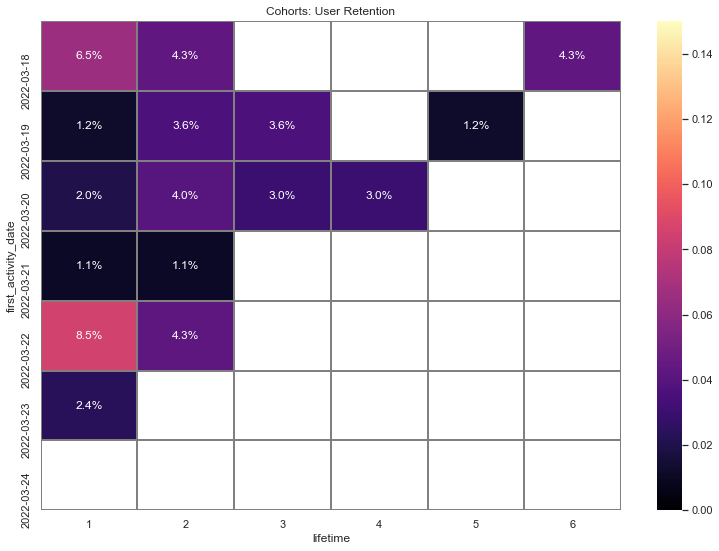

In [41]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot_from_1, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.15, cmap='magma')

so here you can clearly see, why such a short period of time is not suitable for making a cohort analysis, becayse it is mostly a mess

- not enough time to build a proper customer path, retention rate is not representative